In [1]:
import torch
import torchvision 
from tqdm import tqdm
import matplotlib
import torch.nn as nn

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()

        # 定义 MLP 模块
        self.mlp = nn.Sequential(
            nn.Linear(in_features=7 * 7 * 64, out_features=128),  # 全连接层
            nn.ReLU(),  # 激活函数
            nn.Linear(in_features=128, out_features=128),  # 全连接层
            nn.ReLU(),  # 激活函数
        )

        # 定义全连接层
        self.fc1 = nn.Linear(in_features=128, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)  # 展平张量

        # 将展平后的数据输入到 MLP 模块
        x = self.mlp(x)

        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"   # 我这台是cpu
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])

# 定义超参数 && 准备数据集   
BATCH_SIZE = 256
EPOCHS = 10
trainData = torchvision.datasets.MNIST('./data/',train = True,transform = transform,download = True)
testData = torchvision.datasets.MNIST('./data/',train = False,transform = transform)


trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)
net = Net()

lossF = torch.nn.CrossEntropyLoss()                 # 交叉熵损失函数
optimizer = torch.optim.Adam(net.parameters())      # Adam优化器

In [4]:
history = {'Test Loss':[],'Test Accuracy':[]}  # 记录测试集损失和准确率
for epoch in range(1,EPOCHS + 1):
    # 训练集训练
    processBar = tqdm(trainDataLoader,unit = 'step')  # 进度条
    net.train(True)  # 训练模式
    for step,(trainImgs,labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device) 
        labels = labels.to(device)  

        net.zero_grad()  # 梯度清零
        outputs = net(trainImgs)  # 前向传播
        loss = lossF(outputs,labels)  # 计算损失
        predictions = torch.argmax(outputs, dim = 1)  # 获取预测结果
        accuracy = torch.sum(predictions == labels)/labels.shape[0]  # 计算准确率
        loss.backward()  # 反向传播

        optimizer.step()  # 更新参数
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item()))
        
        # 测试集验证
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            net.train(False)  # 测试模式
            with torch.no_grad():  # 不计算梯度 优化性能
                for testImgs,labels in testDataLoader:
                    testImgs = testImgs.to(device) 
                    labels = labels.to(device) 
                    outputs = net(testImgs)  # 前向传播
                    loss = lossF(outputs,labels)  # 计算损失
                    predictions = torch.argmax(outputs,dim = 1)  # 获取预测结果
                    
                    totalLoss += loss  # 累加损失
                    correct += torch.sum(predictions == labels)  # 累加正确预测数
                    
                testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))  # 计算测试集准确率
                testLoss = totalLoss/len(testDataLoader)  # 计算测试集平均损失
                history['Test Loss'].append(testLoss.item())  # 记录测试集损失
                history['Test Accuracy'].append(testAccuracy.item())  # 记录测试集准确率
            
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()  # 关闭进度条


[1/10] Loss: 1.5912, Acc: 0.9271, Test Loss: 1.5882, Test Acc: 0.8545: 100%|██████████| 235/235 [00:19<00:00, 11.80step/s]
[2/10] Loss: 1.5857, Acc: 0.8958, Test Loss: 1.5694, Test Acc: 0.8715: 100%|██████████| 235/235 [00:20<00:00, 11.67step/s]
[3/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4829, Test Acc: 0.9556: 100%|██████████| 235/235 [00:22<00:00, 10.35step/s]
[4/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4767, Test Acc: 0.9617: 100%|██████████| 235/235 [00:21<00:00, 11.05step/s]
[5/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4773, Test Acc: 0.9610: 100%|██████████| 235/235 [00:20<00:00, 11.54step/s]
[6/10] Loss: 1.4612, Acc: 0.9688, Test Loss: 1.4759, Test Acc: 0.9623: 100%|██████████| 235/235 [00:20<00:00, 11.57step/s]
[7/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4812, Test Acc: 0.9567: 100%|██████████| 235/235 [00:20<00:00, 11.56step/s]
[8/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4728, Test Acc: 0.9650: 100%|██████████| 235/235 [00:20<00:00, 11.32step/s]
[9/10] Loss: 1.4

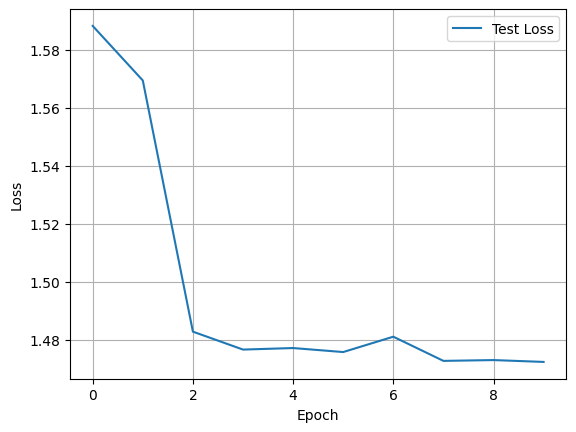

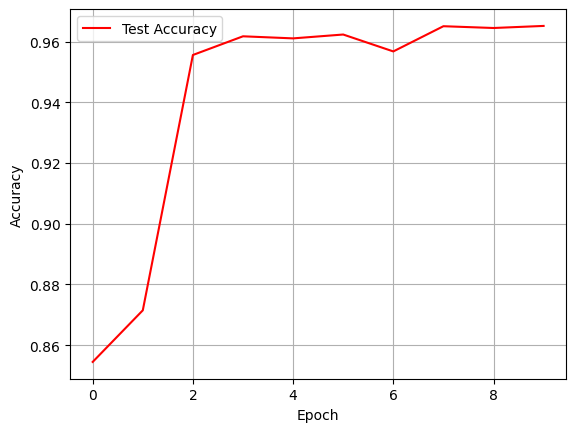

In [5]:
import os
import matplotlib.pyplot as plt

plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 确保路径存在
os.makedirs(os.path.dirname('./model.pth'), exist_ok=True)

torch.save(net, './model.pth')  # 保存模型